## Getting started - deduplication demo

This example shows how to de-duplicate a small dataset using simple settings. 

The aim is to demonstarate core Splink functionality succinctly, rather that comprehensively document all configuration options.

We use the `duckdb` backend, which is the recommended option for smaller datasets of up to around 1 million records on a normal laptop.

In [1]:

%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/Users/robinlinacre/Documents/data_linking/splink/')

import pandas as pd 
pd.options.display.max_columns = 1000


In [2]:
from splink.duckdb.duckdb_linker import DuckDBLinker

## Step 1: Read in data


In [3]:
import pandas as pd 
pd.options.display.max_rows = 1000
df = pd.read_csv("./data/fake_1000.csv")
df.head(5)

,unique_id,first_name,surname,dob,city,email,cluster
0,0,Robert,Alan,1971-06-24,NaN,robert255@smith.net,0
1,1,Robert,Allen,1971-05-24,NaN,roberta25@smith.net,0
2,2,Rob,Allen,1971-06-24,London,roberta25@smith.net,0
3,3,Robert,Alen,1971-06-24,Lonon,NaN,0
4,4,Grace,NaN,1997-04-26,Hull,grace.kelly52@jones.com,1


Note that the `cluster` column represents the 'ground truth' - a column which tells us with which rows refer to the same person.  In most real linkage scenarios, we wouldn't have this column (this is what Splink is trying to estimate.)

## Step 2: Exploratory analysis

Splink contains exploratory analysis tools designed to highlight the aspects of your data most relevant to data linking - things like missingness, skew, and whether further data cleaning may be needed prior to linking.

This is useful for understanding your data, whether it suffers from skew, and whether additional data cleaning may be necessary.

In [4]:
# Initialise the linker, passing in the input dataset(s)
linker = DuckDBLinker(df)

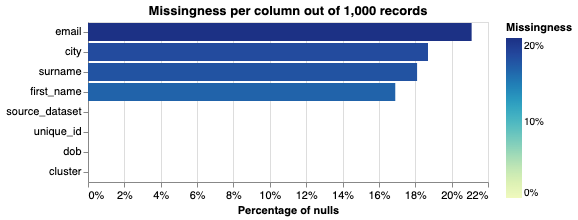

In [5]:
import altair as alt
alt.renderers.enable('mimetype')
linker.missingness_chart()

The `profile_columns` method creates summary charts.  You may input column names (e.g. `first_name`), or arbitrary sql expressions like `concat(first_name, surname)`).  

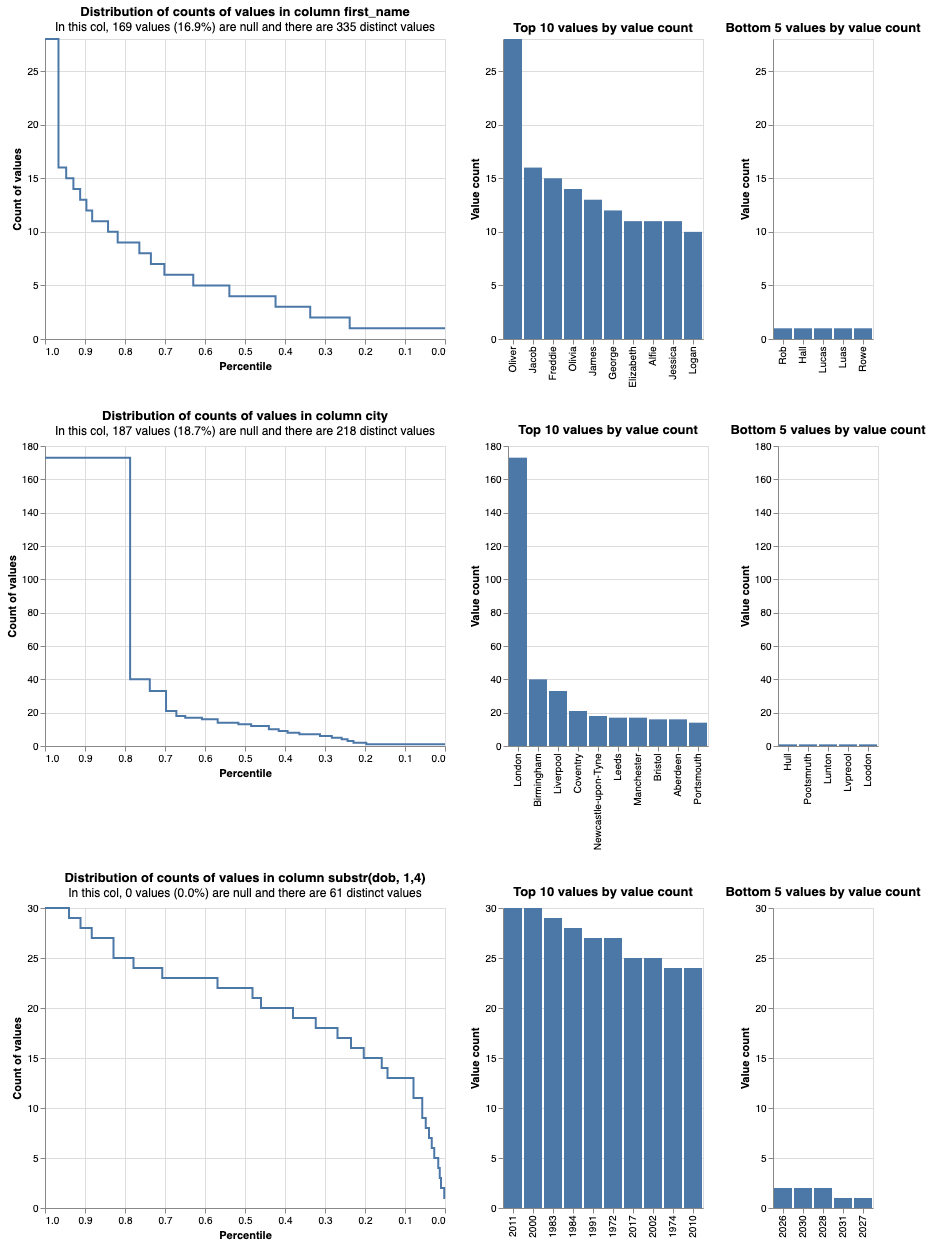

In [6]:
linker.profile_columns(["first_name", "city", "substr(dob, 1,4)"], top_n=10, bottom_n=5)

In [7]:
linker.compute_number_of_comparisons_generated_by_blocking_rule("l.first_name = r.first_name")

{'count_of_pairwise_comparisons_generated': 1998}

## Step 3: Configure how Splink compares records using a `settings` dictionary

`splink` needs to know how to compare pairs records from the input dataset, with the aim of computing an overall score that quantifies the similarity.

For example, here is a pair of records from our input dataset.  


|   unique_id | first_name   | surname   | dob        | city   | email               |
|------------:|:-------------|:----------|:-----------|:-------|:--------------------|
|           1 | Robert       | Allen     | 1971-05-24 | nan    | roberta25@smith.net |
|           2 | Rob          | Allen     | 1971-06-24 | London | roberta25@smith.net |

What functions should we use to assess the similarity of `Rob` vs. `Robert` in the the `first_name` field?

This is configured using a `settings` dictionary.  

Rules are defined that map similarity to discrete number levels, known as "comparison levels".

In this introductory example, we will make these comparisons simple:  

- For the `first_name` column, there will be three comparison levels:
  - an 'exact match' (e.g. `John` vs `John`)
  - similar but not the exactly the same (e.g. `John` vs `Jon`).  Specifically this will be defined as a levenshtein distance of either 1 or 2.
  - all other comparisons 

- For all other comparisons, we will model just two comparison levels: an 'exact match' (e.g. `Smith` vs `Smith`), or 'anything else' (e.g. `Smith` vs `Jones`, or even `Smith` vs `Smyth`).

- For `city`, we enable term frequency comparisons because we observed significant skew in the distribution of values

In [8]:
from splink.comparison_library import exact_match, levenshtein
settings = {
    "proportion_of_matches": 0.01,
    "link_type": "dedupe_only",
    "comparisons": [
        levenshtein("first_name", 2),
        exact_match("surname"),
        exact_match("dob"),
        exact_match("city", term_frequency_adjustments=True),
        exact_match("email"),
    ],
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name",
        "l.surname = r.surname",
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
    "additional_columns_to_retain": ["cluster"],
}

In words, this setting dictionary says:

* We are performing a deduplication task (the other options are `link_only`, or `link_and_dedupe`, which may be used if there are multiple input datasets)

* When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
* The `blocking_rules_to_generate_predictions` states that we will only check for duplicates amongst records where either the `first_name` or `surname` is identical.
* We have enabled term frequency adjustments for the 'city' column, because some values (e.g. `London`) appear much more frequently than others
* We will retain the cluster column in the results even though this is not used as part of comparisons. Later we'll be able to use this to compare Splink scores to the ground truth.
* We have set `retain_intermediate_calculation_columns` and `additional_columns_to_retain` to `True` for the purposes of the demo, because this will mean the output datasets contain additional information that, whilst not strictly needed by Splink, helps the user understand the calculations. If these were omitted from the settings dictionary, they would be set to `False` (their default value).

## Step 4: Estimate the parameters of the model


Use the `train_u_using_random_sampling` to compute the `u` values of the model.

In [9]:
linker.initialise_settings(settings)
linker.estimate_u_using_random_sampling(target_rows=1e6)

----- Training u probabilities using random sampling -----

Trained u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trained).
    - dob (no m values are trained).
    - city (no m values are trained).
    - email (no m values are trained).


We then use the expectation maximisation algorithm to train the `m` values.

Note that in this first EM training session we block on `first_name` and `surname`, meaning that all comparisons will have `first_name` and `surname` exactly equal.   This means that, in this training session, we cannot estimate parameter estimates for the `first_name` or `surname` columns, as seen in the log messages, and their absence from the match weights chart.


----- Starting EM training session -----

Training the m probabilities of the model by blocking on:
l.first_name = r.first_name and l.surname = r.surname

Parameter estimates will be made for the following comparison(s):
    - dob
    - city
    - email

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - first_name
    - surname

Iteration 1: Largest change in params was -0.491 in the m_probability of dob, level `Exact match`
Iteration 2: Largest change in params was 0.0292 in the m_probability of city, level `All other comparisons`
Iteration 3: Largest change in params was 0.0185 in proportion_of_matches
Iteration 4: Largest change in params was 0.0131 in proportion_of_matches
Iteration 5: Largest change in params was 0.00966 in proportion_of_matches
Iteration 6: Largest change in params was 0.00741 in proportion_of_matches
Iteration 7: Largest change in params was 0.00585 in proportion_of_matches
Iteration 8: Largest 

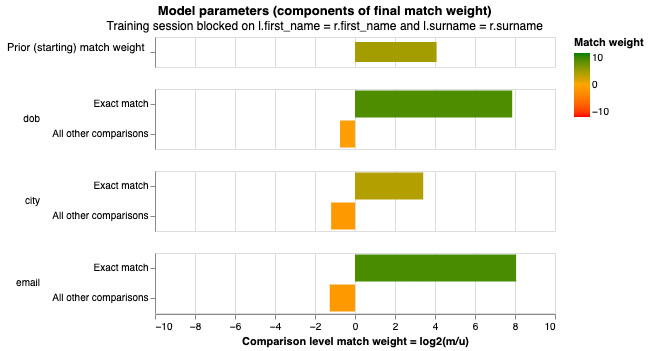

In [10]:
training_blocking_rule = "l.first_name = r.first_name and l.surname = r.surname"
training_session_names = linker.estimate_parameters_using_expectation_maximisation(training_blocking_rule)

training_session_names.match_weights_interactive_history_chart()

In a second training session, we block on `dob`.  This allows us to estimate parameters for the `first_name ` and `surname` comparisons.

Between the two training sessions, we now have parameter estimates for all comparisons.


----- Starting EM training session -----

Training the m probabilities of the model by blocking on:
l.dob = r.dob

Parameter estimates will be made for the following comparison(s):
    - first_name
    - surname
    - city
    - email

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - dob

Iteration 1: Largest change in params was 0.457 in proportion_of_matches
Iteration 2: Largest change in params was 0.176 in proportion_of_matches
Iteration 3: Largest change in params was 0.0637 in proportion_of_matches
Iteration 4: Largest change in params was 0.0295 in proportion_of_matches
Iteration 5: Largest change in params was 0.0163 in proportion_of_matches
Iteration 6: Largest change in params was 0.0101 in proportion_of_matches
Iteration 7: Largest change in params was 0.00663 in proportion_of_matches
Iteration 8: Largest change in params was 0.00457 in proportion_of_matches
Iteration 9: Largest change in params was 0.00325

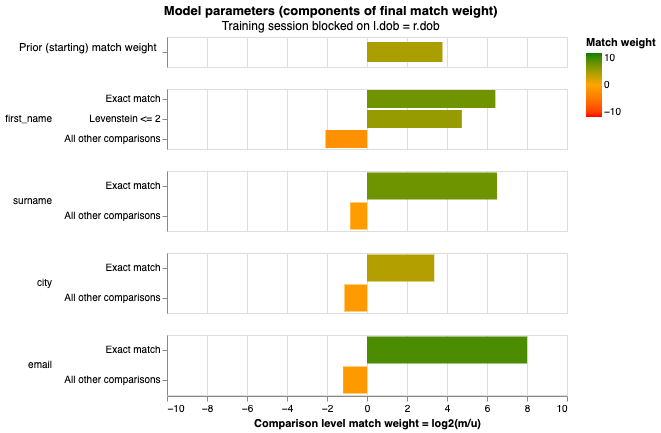

In [11]:
training_blocking_rule = "l.dob = r.dob"
training_session_dob = linker.estimate_parameters_using_expectation_maximisation(training_blocking_rule)
training_session_dob.match_weights_interactive_history_chart()

The final match weights can be viewed in the match weights chart:

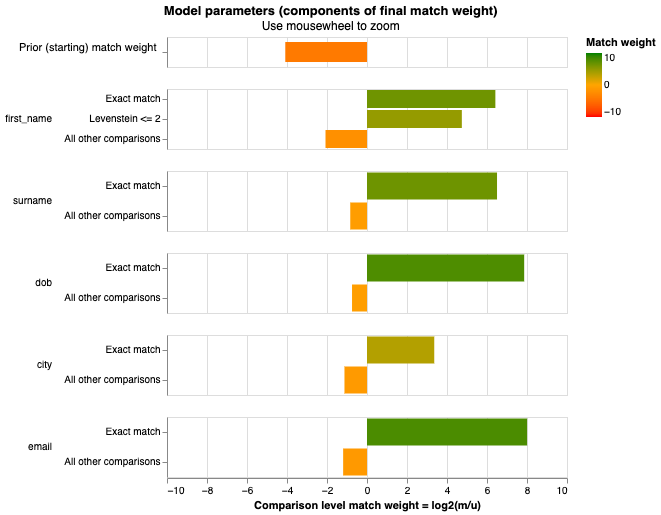

In [13]:
linker.match_weights_chart()

## Step 7: Predicting match weights using the trained model 

In [16]:
df_predictions.as_pandas_dataframe(limit=5)

,match_weight,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,bf_first_name,surname_l,surname_r,gamma_surname,bf_surname,dob_l,dob_r,gamma_dob,bf_dob,city_l,city_r,gamma_city,bf_city,bf_tf_adj_city,tf_city_l,tf_city_r,email_l,email_r,gamma_email,bf_email,cluster_l,cluster_r,match_key
0,9.588848,0.998703,4,5,Grace,Grace,2,85.540146,NaN,Kelly,-1,1.000000,1997-04-26,1991-04-26,0,0.595211,Hull,NaN,-1,1.000000,1.0,0.00123,NaN,grace.kelly52@jones.com,grace.kelly52@jones.com,1,256.835336,1,1,0
1,-0.445665,0.423381,9,922,Evie,Evie,2,85.540146,Dean,Jones,0,0.559746,2015-03-03,2002-07-22,0,0.595211,Pootsmruth,NaN,-1,1.000000,1.0,0.00123,NaN,evihd56@earris-bailey.net,eviejones@brewer-sparks.org,0,0.437496,3,230,0
2,-0.445665,0.423381,14,998,Oliver,Oliver,2,85.540146,Griffiths,Bird,0,0.559746,1991-10-26,2000-02-27,0,0.595211,Lunton,NaN,-1,1.000000,1.0,0.00123,NaN,o.griffiths90@reyes-coleman.com,oliver.b@smith.net,0,0.437496,5,250,0
3,0.746993,0.626628,18,475,Caleb,Caleb,2,85.540146,Rwoe,Scott,0,0.559746,1992-11-20,2000-12-10,0,0.595211,Liverpool,NaN,-1,1.000000,1.0,0.04059,NaN,NaN,c.scott@brooks.com,-1,1.000000,8,119,0
4,-1.572324,0.251646,21,917,Darcy,Darcy,2,85.540146,Bernass,Rhodes,0,0.559746,1986-02-04,1979-01-14,0,0.595211,Southampton,Birmingham,0,0.457975,1.0,0.00861,0.0492,darcy.b@silva.com,drhodes16@johnson-robinson.com,0,0.437496,9,229,0


In [15]:
df_predictions = linker.predict()
df_predictions

Table name in database: `__splink__df_predict_957567d`

To retrieve records, you can call the following methods on this object:
`.as_record_dict(limit=5)` or `.as_pandas_dataframe(limit=5)`.

You may omit the `limit` argument to return all records.

This table represents the following splink entity: __splink__df_predict

## Step 8: Visualising results

We can view the output table as follows

You can also view rows in this dataset as a waterfall chart as follows:

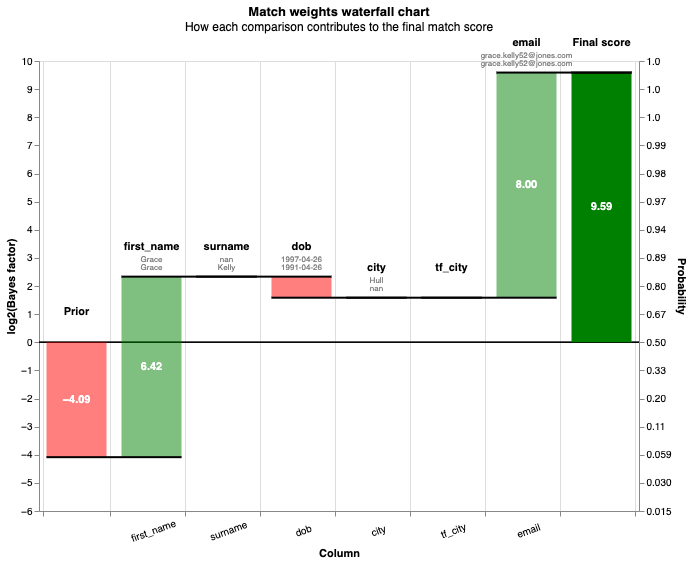

In [18]:
from splink.charts import waterfall_chart
records_to_plot = df_predictions.as_record_dict(limit=5)
linker.waterfall_chart(records_to_plot, filter_nulls=False)

We can visualise a sample of individual record comparisons using a waterfall chart:

A histogram showing the distribution of match weights can be viewed as follows

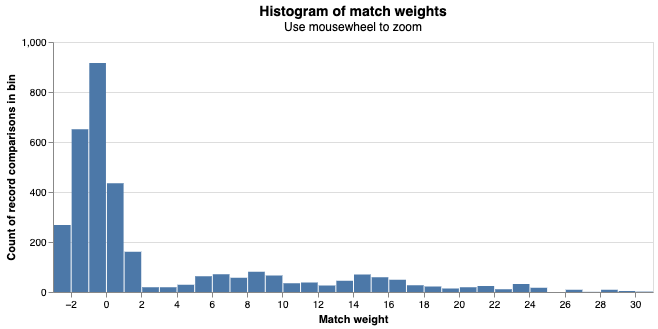

In [20]:
linker.match_weight_histogram(df_predictions)

If you have a sample of labels, you can output a ROC chart.  (A precision-recall chart is also available with `linker.precision_recall_from_labels`) 

Your labels need to be formatted as follows:

## Step 9: Accuracy analysis

Since we have labels in this dataset, we can compute the accuracy of our trained model

In [21]:
df_labels = pd.read_csv("./data/fake_1000_labels.csv")
df_labels.head(5)

,unique_id_l,source_dataset_l,unique_id_r,source_dataset_r,clerical_match_score
0,0,fake_1000,1,fake_1000,1.0
1,0,fake_1000,2,fake_1000,1.0
2,0,fake_1000,3,fake_1000,1.0
3,0,fake_1000,4,fake_1000,0.0
4,0,fake_1000,5,fake_1000,0.0


Then to produce the chart:

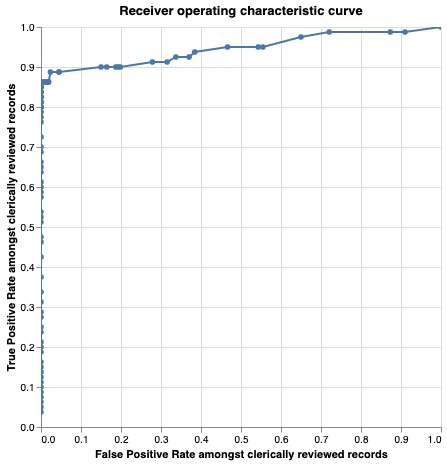

In [22]:
linker._con.register("labels", df_labels)

linker.roc_chart_from_labels("labels")

### Step 10: Splink comparison viewer

Create a [splink_comparison_viewer](https://www.youtube.com/watch?v=DNvCMqjipis) interactive dashboard and display in an iframe

In [23]:
linker.splink_comparison_viewer(df_predictions, "scv.html", True,2)

from IPython.display import IFrame

IFrame(
    src="./scv.html", width=1400, height=1200
)  